![terrainbento logo](../images/terrainbento_logo.png)


# Introduction to terrainbento


## Overview
This tutorial shows example usage of terrainbento and highlights some of its features. For comprehensive information about all options and defaults, refer to the [documentation](http://terrainbento.readthedocs.io/en/latest/). 

## Prerequisites
This tutorial assumes you have at least skimmed the [terrainbento manuscript](https://www.geosci-model-dev.net/12/1267/2019/).

### terrainbento base classes

All aspects setting up the Landlab model grid and boundary conditions are handled by the three model base classes. [**ErosionModel**](http://terrainbento.readthedocs.io/en/latest/source/terrainbento.base_class.erosion_model.html) handles functionality common to all models, [**StochasticErosionModel**](http://terrainbento.readthedocs.io/en/latest/source/terrainbento.base_class.stochastic_erosion_model.html) handles additional routines requierd by **St** models which include stochastic discharge, and [**TwoLithologyErosionModel**](http://terrainbento.readthedocs.io/en/latest/source/terrainbento.base_class.two_lithology_erosion_model.html) handles setting up the lithology contact boundary used by all **Rt** models.

### Creating a terrainbento model
There are three ways to create a terrainbento model. 

1. All necessary inputs can be passed to the `__init__` method of the terrainbento model. 
2. The model can be constructed from a [dictionary](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)
3. A dictionary can be read from a [YAML](http://yaml.org/start.html) style input file. 

In this tutorial we will use option 2. 

The parameter dictionary may include information to control a **BoundaryHandler**, a model class used to modify the boundary conditions of a model during run time. A more comprehensive introduction to using **BoundaryHandlers** is located in [this tutorial](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb). It will also specify the **Precipitator** and the **RunoffGenerator**. If the default values are used for these two inputs, the model will use drainage area in place of discharge. 

### Model output options
By default terrainbento will save a [NetCDF](https://www.unidata.ucar.edu/software/netcdf/) file at equal intervals specified by the ``output_interval`` parameter. For many applications it may be sufficient to run a model, save output, and then open the stack of NetCDFs for postprocessing (we recommend [xarray](http://xarray.pydata.org/en/stable/) and [holoviews](http://holoviews.org) for opening, analyzing, and plotting stacks of NetCDFs in python). 

If in your application, you want to have additional output written at the ``output_interval`` intervals, you can pass any number of functions or classes that write this ouput to terrainbento. These functions and classes are called **OutputWriters** and a detailed desription of their use can be found in [this tutorial](http://localhost:8888/notebooks/example_usage/introduction_to_output_writers.ipynb).

### terrainbento and units
terrainbento assumes that you are consistent with your length and time units. The length unit is implied by the units of the model dx spacing and the time unit is implied by the units of the run duration and dt. 

## Examples
In the following examples we will use the [**Basic** model](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.derived_models.model_basic.html) and the [**BasicVs** model](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.derived_models.model_basicVs.html).

Model **Basic** uses stream power and linear diffusion and has the following governing equation:

$\frac{\partial \eta}{\partial t} = - KQ^{m}S^{n} + D\nabla^2 \eta$

where $K$ and $D$ are constants, $Q$ is discharge, $S$ is local slope, and $\eta$ is the topography. Other models modify Basic by adding or changing a process component and changing the governing equation. 

Model **BasicVs** has a slightly different governing equation. 

$\frac{\partial \eta}{\partial t} = - K R_m A_{eff}^{m}S^{n} + D\nabla^2 \eta$

where

$A_{eff} = A e^{-\alpha S / A}$

and  

$\alpha = \frac{K_{sat}  H  dx}{R_m}$.

Here $A$ is the local upstream drainage area, $R_m$ is the average recharge (or precipitation) rate, $A_{eff}$ is the effective drainage area, $K_{sat}$ is the hydraulic conductivity, $H$ is the soil thickness, and $dx$ is the grid cell width. $\alpha$ is a courtesy parameter called the "saturation area scale" that lumps together many constants.

Refer to [Barnhart et al. (2019)](https://www.geosci-model-dev.net/12/1267/2019/) for the definition of all symbols.

To create an instance of a terrainbento model we must first create an input parameter dictionary. In this tutorial, we will not cover all possible options for instatiating a  model. Refer to the [**ErosionModel** documentation](http://terrainbento.readthedocs.io/en/latest/source/terrainbento.base_class.erosion_model.html) for a comprehensive list of options. 

First we will import all the modules we need. 

In [1]:
import numpy as np
np.random.seed(42)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
hv.notebook_extension('matplotlib')

from terrainbento import Basic, BasicVs

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

Next we will create the parameter dictionary needed to instantiate the **Basic** model. All parameters used are specified in this notebook block. Refer to the base class and individual model documentation for required parameters. 

In [2]:
basic_params = {
    # create the Clock.
    "clock": {
        "start": 0,
        "step": 1000,
        "stop": 2e5
    },

    # Create the Grid
    "grid": {
        "RasterModelGrid": [
            (25, 40),
            {
                "xy_spacing": 40
            },
            {
                "fields": {
                    "node": {
                        "topographic__elevation": {
                            "random": [{
                                "where": "CORE_NODE"
                            }]
                        }
                    }
                }
            },
        ]
    },

    # Set up Boundary Handlers
    "boundary_handlers": {
        "NotCoreNodeBaselevelHandler": {
            "modify_core_nodes": True,
            "lowering_rate": -0.001
        }
    },
    # Parameters that control output.
    "output_interval": 5e3,
    "save_first_timestep": True,
    "output_prefix": "model_basic_output",
    "fields": ["topographic__elevation"],

    # Parameters that control process and rates.
    "water_erodibility": 0.00005,
    "m_sp": 0.5,
    "n_sp": 1.0,
    "regolith_transport_parameter": 0.01,
}

Performing list(d) on a dictionary returns a list of all the keys used in the dictionary

In [3]:
list(basic_params)

['clock',
 'grid',
 'boundary_handlers',
 'output_interval',
 'save_first_timestep',
 'output_prefix',
 'fields',
 'water_erodibility',
 'm_sp',
 'n_sp',
 'regolith_transport_parameter']

You see that clock is listed as a sub-directory. Can you find a way to print out the key:value pairs of clock? 
[**Some additional info**](https://docs.python.org/3/tutorial/datastructures.html#dictionaries)

In [4]:
list(basic_params['clock'])

['start', 'step', 'stop']

Here we've used the ``NotCoreNodeBaselevelHander``. This is a class in terrainbento that modifies the model boundary conditions. The documentation for this baselevel handler is located [here](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.boundary_handlers.not_core_node_baselevel_handler.html), a tutorial about this and other terrainbento baselevel handlers is located [here](http://localhost:8888/notebooks/example_usage/introduction_to_boundary_conditions.ipynb). 

In [5]:
basic = Basic.from_dict(basic_params)
basic.run()

Really! That is all you need to do to run the model. NetCDF output of the model was saved at timesteps specified by `output_interval`. If you want to have other output saved, see the [terrainbento OutputWriter tutorial](http://localhost:8888/notebooks/example_usage/introduction_to_output_writers.ipynb).  

In the remainder of the tutorial we will first make a plot, and the highlight the multi-model functionality of terrainbento. 


### Making a plot

terrainbento has a function called `to_xarray_dataset` that will take all the model output and combine it into one xarray datset. 
[More info on xarray datasets](http://xarray.pydata.org/en/stable/data-structures.html)

In [6]:
ds = basic.to_xarray_dataset(time_unit='years', space_unit='meters')

We can look at what is in this xarray dataset. Because we only asked to save the field `topographic__elevation`, it is the only data variable. It has x, y, and time coordinates cooresponding to the x and y model grid space, and the timestep saved by the parameter `output_interval`.

In [7]:
ds

<xarray.Dataset>
Dimensions:                 (time: 41, x: 40, y: 25)
Coordinates:
  * y                       (y) float64 0.0 40.0 80.0 ... 880.0 920.0 960.0
  * x                       (x) float64 0.0 40.0 80.0 ... 1.52e+03 1.56e+03
  * time                    (time) float64 0.0 5e+03 1e+04 ... 1.95e+05 2e+05
Data variables:
    topographic__elevation  (time, y, x) float64 dask.array<chunksize=(1, 25, 40), meta=np.ndarray>

To use Holoviews to make a plot we first create a holoviews dataset. 

In [8]:
hvds_topo = hv.Dataset(ds.topographic__elevation)

Then we make a plot. Here we are will make an image plot with a time slider. Holoviews will render each image before showing the result so executing this cell may take a few moments. 

:HoloMap   [time]
   :Image   [x,y]   (topographic__elevation)
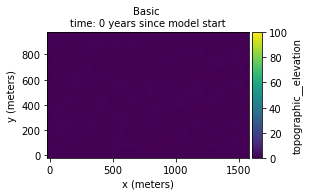
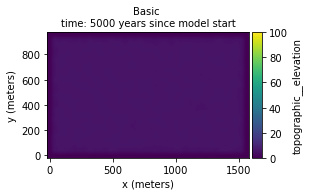
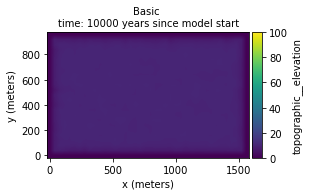
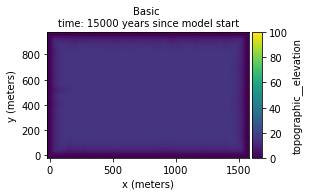
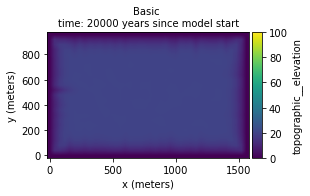
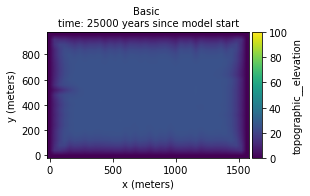
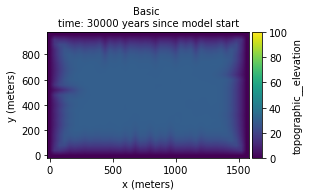
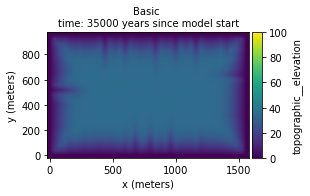
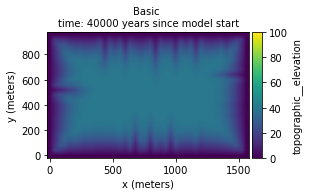
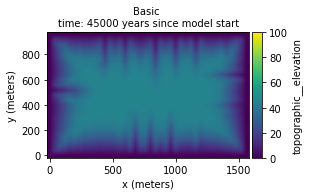
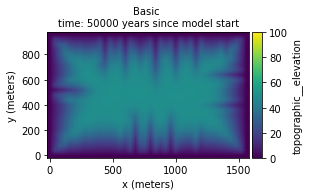
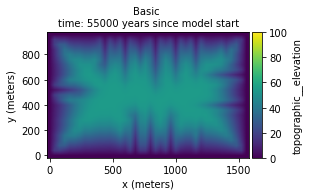
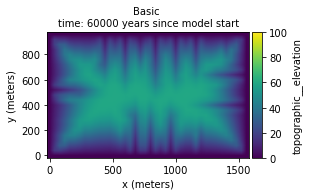
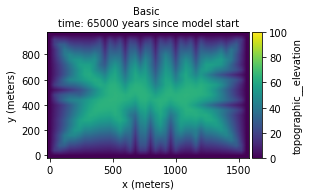
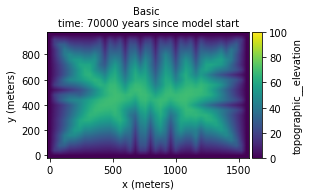
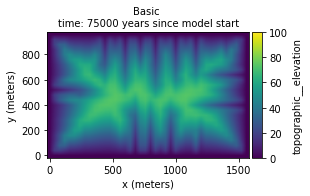
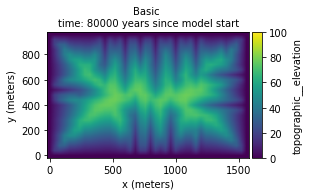
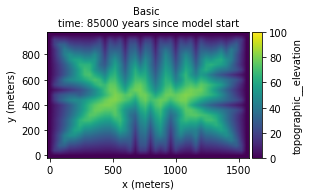
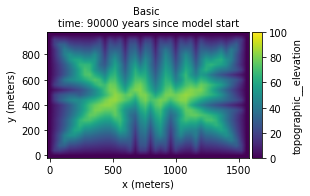
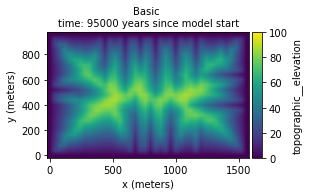
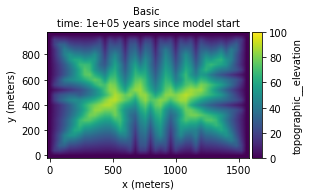
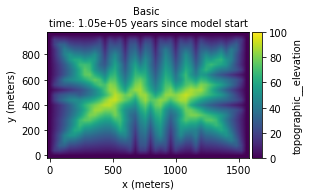
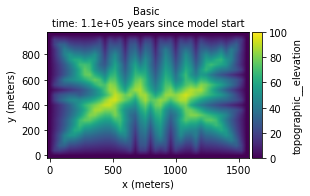
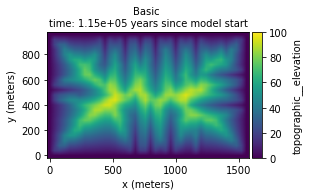
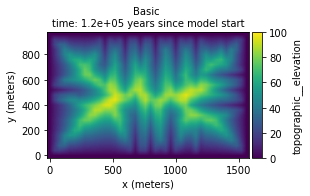
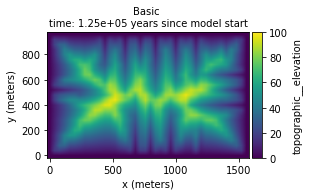
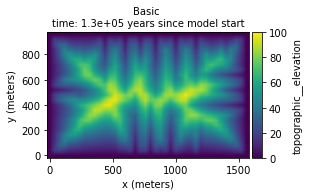
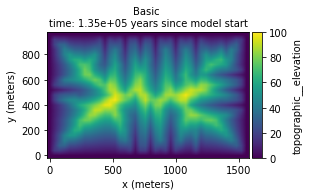
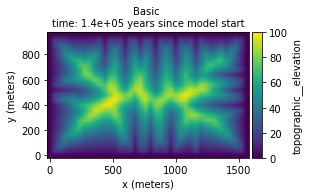
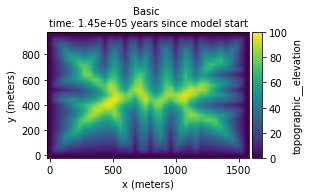
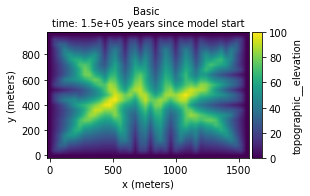
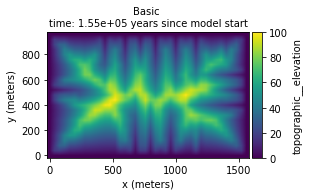
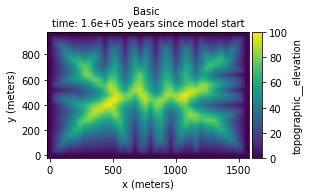
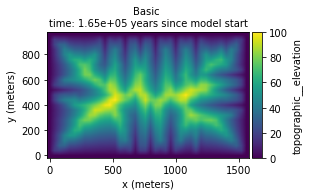
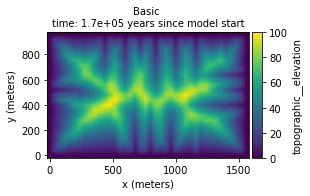
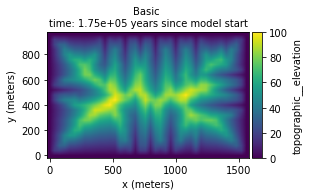
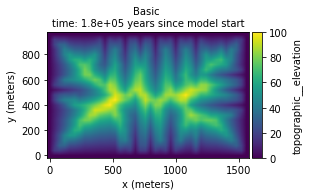
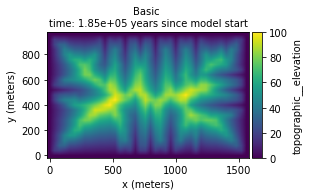
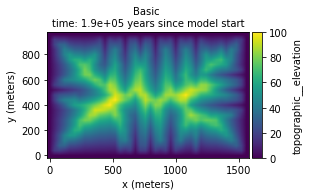
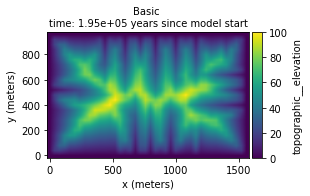
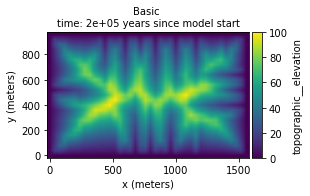

In [9]:
topo = hvds_topo.to(hv.Image, ['x', 'y'],
                    label='Basic').options(interpolation='bilinear',
                                           cmap='viridis',
                                           colorbar=True)
topo.opts(fontsize={
    'title': 10, 
    'labels': 10, 
    'xticks': 10, 
    'yticks': 10,       
    'cticks': 10,
})
topo

As you can see we have evolved some topography. 

### Comparing multiple models

terrainbento was designed to make it easy to compare alternative model structures in lanscape evolution modeling. So next we will compare the **Basic** model with a **BasicVs** model. 

We need to add the new parameters required by **BasicVs** and we will change the name of the output file. 

In [10]:
basicvs_params = {
    # create the Clock.
    "clock": {
        "start": 0,
        "step": 1000,
        "stop": 2e5
    },

    # Create the Grid.
    "grid": {
        "RasterModelGrid": [(25, 40), {
            "xy_spacing": 40
        }, {
            "fields": {
                "node": {
                    "topographic__elevation": {
                        "random": [{
                            "where": "CORE_NODE"
                        }]
                    },
                    "soil__depth": {
                        "constant": [{
                            "value": 1.0
                        }]
                    }
                }
            }
        }]
    },

    # Set up Boundary Handlers
    "boundary_handlers": {
        "NotCoreNodeBaselevelHandler": {
            "modify_core_nodes": True,
            "lowering_rate": -0.001
        }
    },
    # Set up Precipitator
    "precipitator": {
        "UniformPrecipitator": {
            "rainfall_flux": 0.01
        }
    },

    # Parameters that control output.
    "output_interval": 5e3,
    "save_first_timestep": True,
    "output_prefix": "model_basicvs_output",
    "fields": ["topographic__elevation"],

    # Parameters that control process and rates.
    "water_erodibility": 0.00005,
    "m_sp": 0.5,
    "n_sp": 1.0,
    "regolith_transport_parameter": 0.01,
    "hydraulic_conductivity": 15,
}

basicvs = BasicVs.from_dict(basicvs_params)
basicvs.run()
ds2 = basicvs.to_xarray_dataset(time_unit='years', space_unit='meters')
hvds_topo2 = hv.Dataset(ds2.topographic__elevation, label='Basic')

Now that the model has run, we will make a plot with both the **Basic** and **BasicVs** results. Note that the color axis limits are different in the two plot panels. 

In [11]:
topo2 = hvds_topo2.to(hv.Image, ['x', 'y'],
                      label='BasicVs').options(interpolation='bilinear',
                                               cmap='viridis',
                                               colorbar=True)

:Layout
   .HoloMap.Basic   :HoloMap   [time]
      :Image   [x,y]   (topographic__elevation)
   .HoloMap.BasicVs :HoloMap   [time]
      :Image   [x,y]   (topographic__elevation)
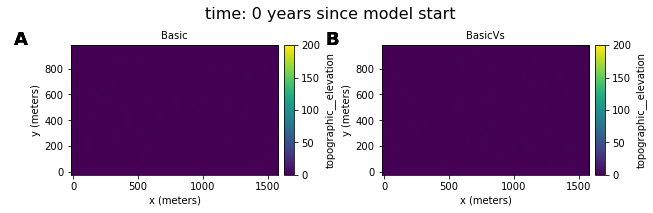
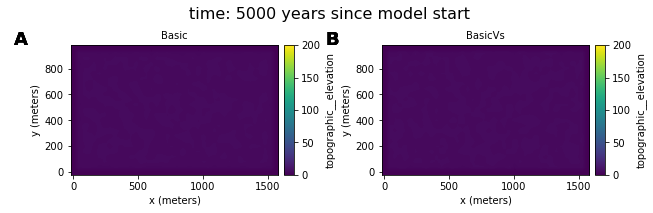
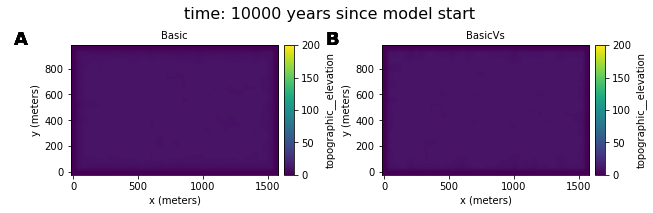
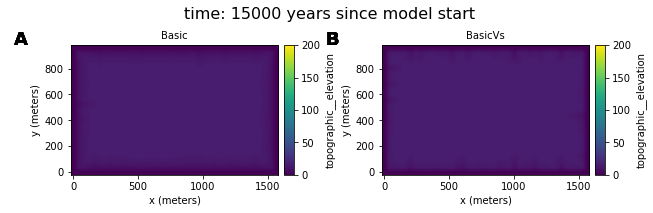
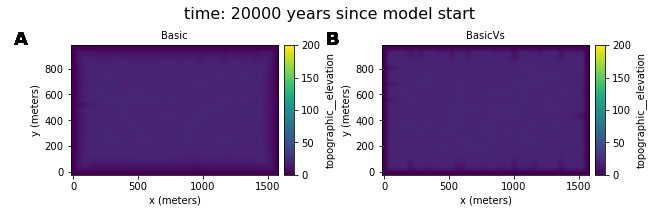
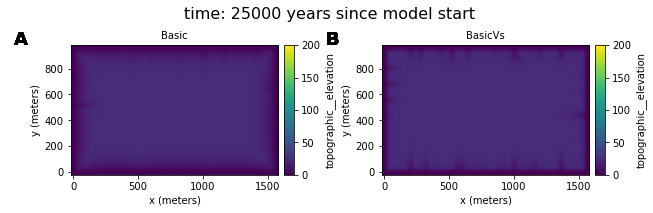
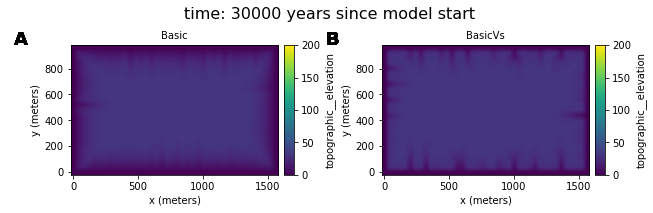
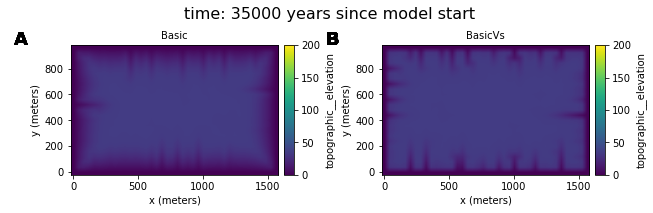
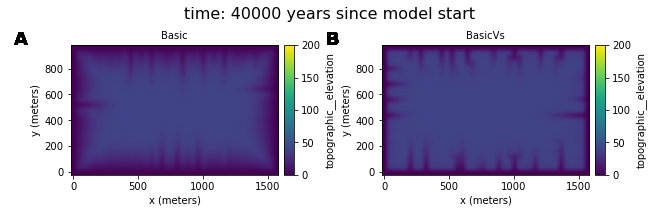
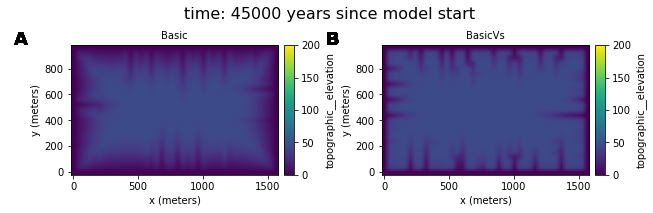
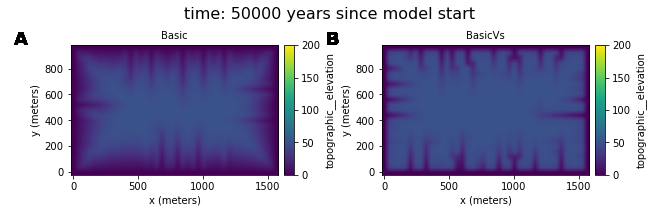
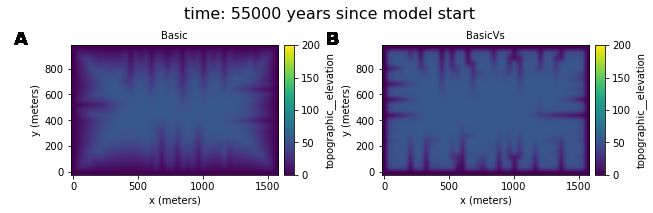
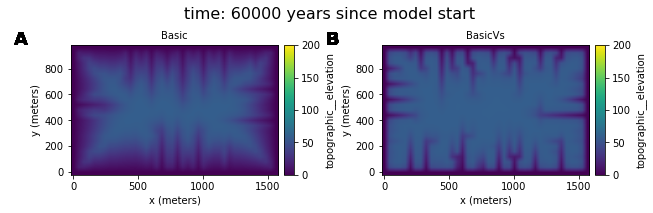
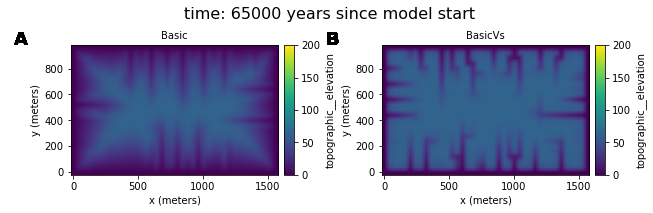
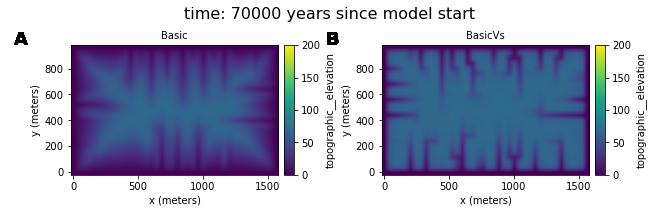
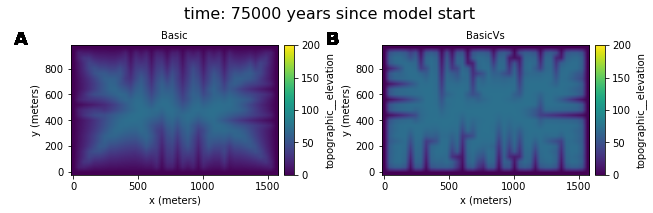
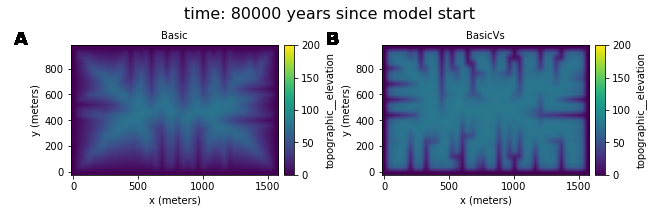
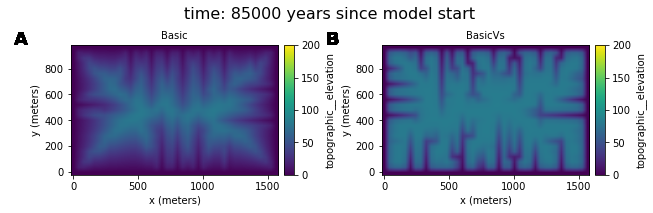
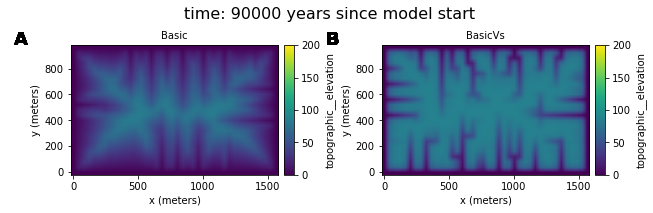
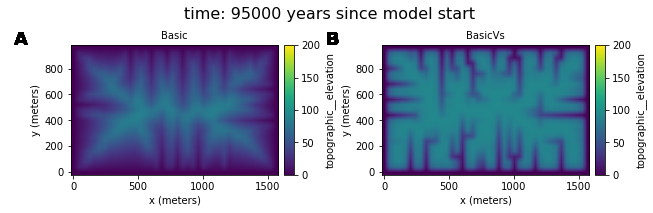
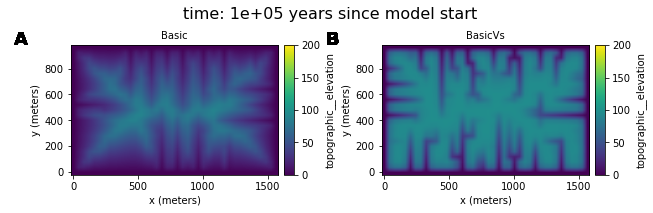
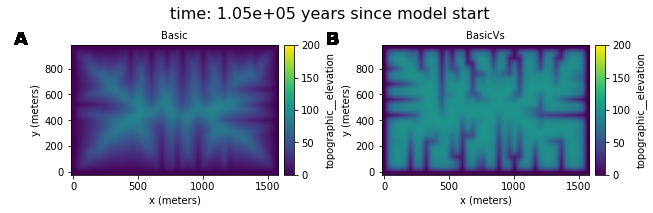
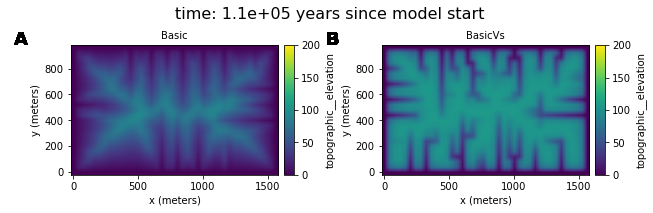
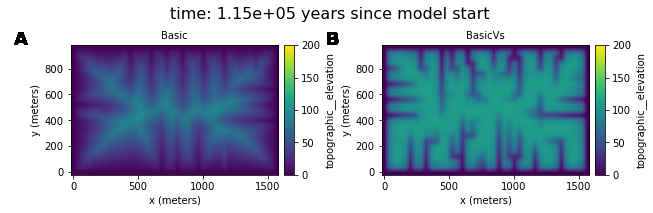
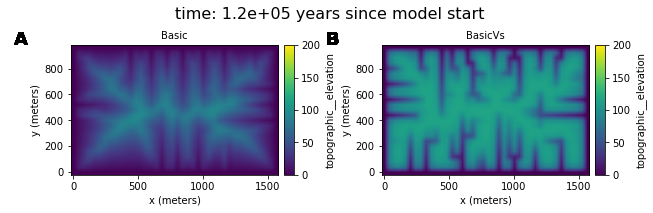
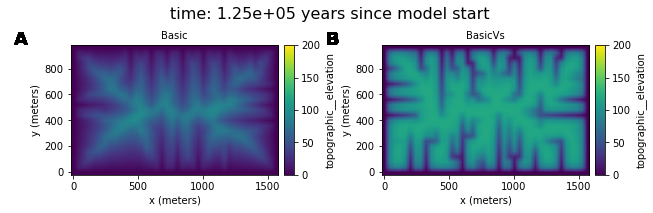
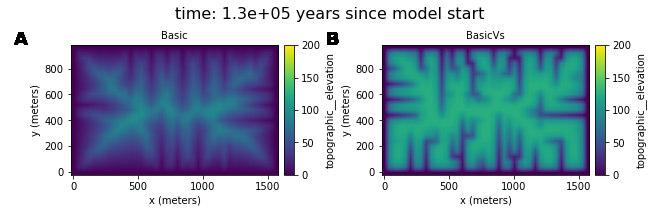
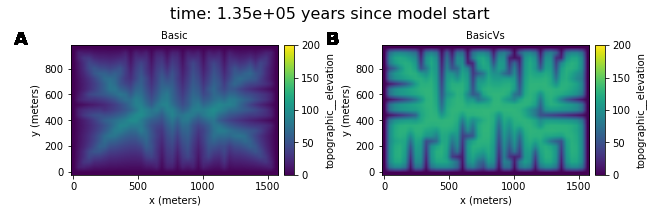
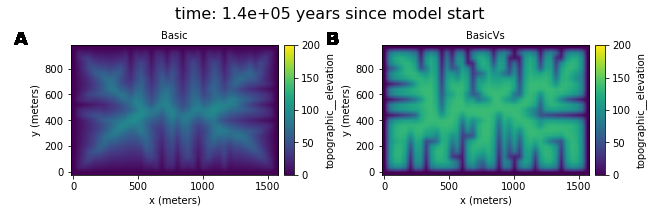
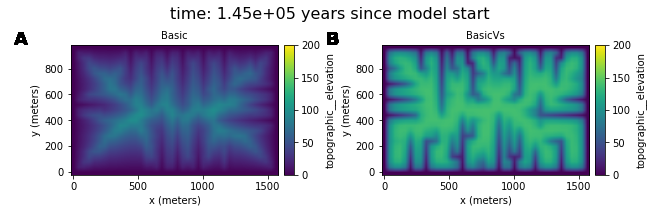
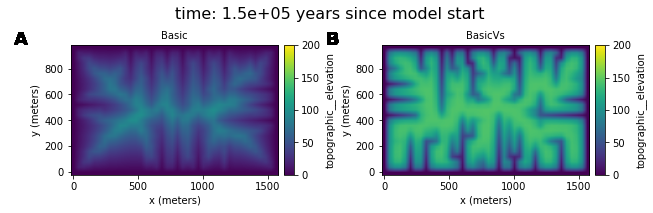
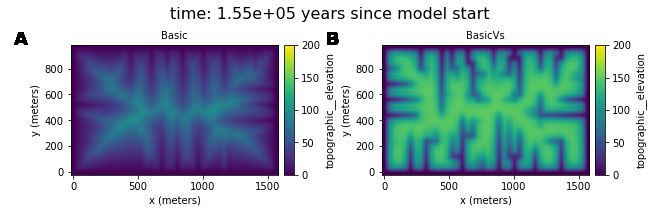
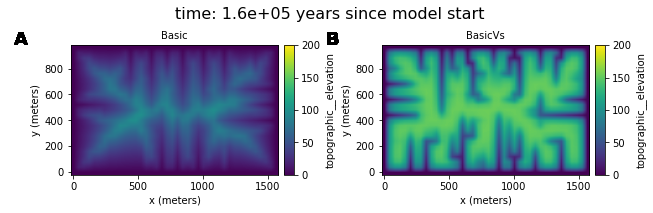
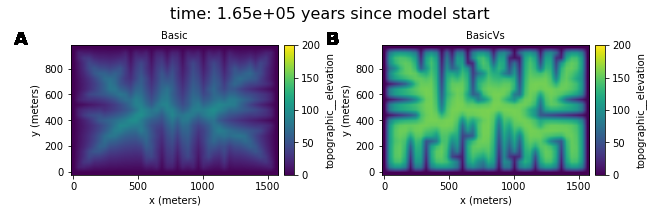
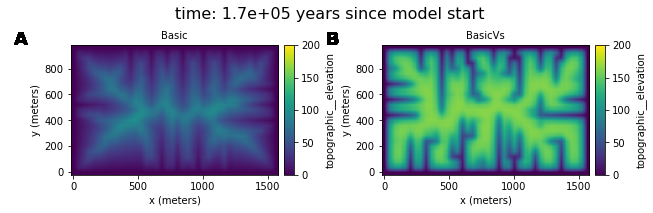
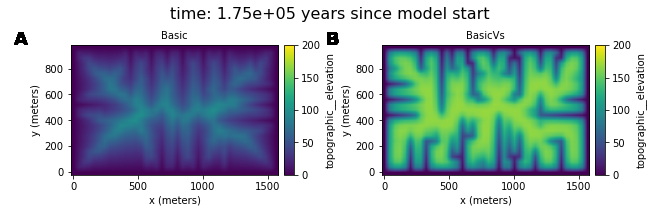
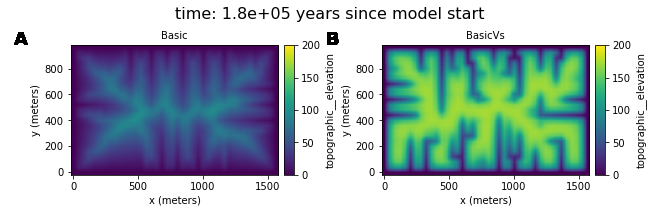
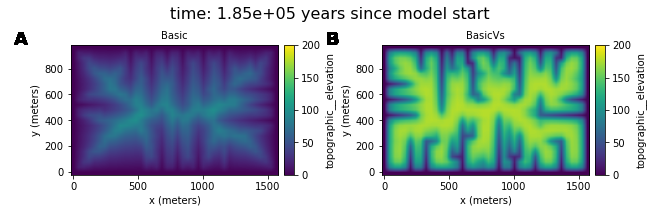
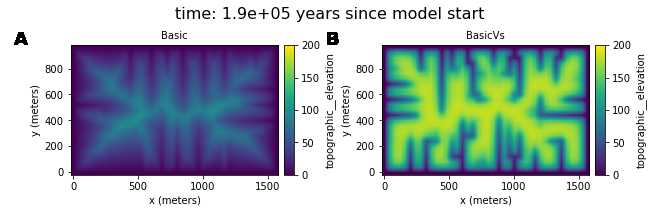
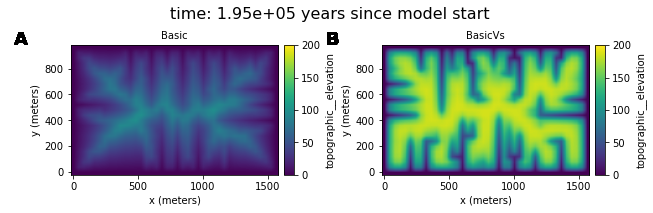
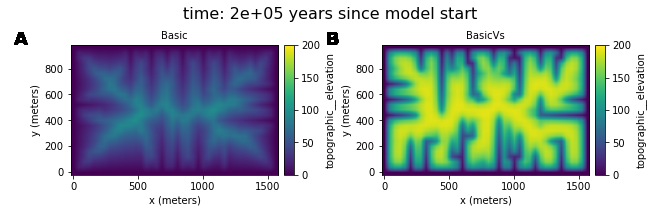

In [15]:
topo = topo.redim.range(topographic__elevation=(0, 200))
topo2 = topo2.redim.range(topographic__elevation=(0, 200))
topo2.opts(fontsize={
    'title': 10, 
    'labels': 10, 
    'xticks': 10, 
    'yticks': 10,       
    'cticks': 10,
})
topo + topo2

As you can see, the landscape created by the **Basic** model is quite different from the **BasicVs** model. This makes sense as the effective drainage area of **BasicVs** is different from the **Basic** model. One thing to think about is how you could quantitatively compare these two output landscapes. 

Finally we can use the model function `remove_output_netcdfs` to remove the files created by running the model. 

In [ ]:
del topo, hvds_topo, topo2, hvds_topo2
ds.close()
ds2.close()
basic.remove_output_netcdfs()
basicvs.remove_output_netcdfs()

## Challenge 

Create and compare two Basic models. 
Model 1 has the following parameter values
- "water_erodibility": 0.00005,
- "m_sp": 0.5,
- "n_sp": 1.0,
- "regolith_transport_parameter": 0.1,

Model 2 has the following parameter values
- "water_erodibility": 0.00005,
- "m_sp": 0.5,
- "n_sp": 1.0,
- "regolith_transport_parameter": 0.001,


## Next Steps

- We recommend you review the [terrainbento manuscript](https://www.geosci-model-dev.net/12/1267/2019/).

- There are three additional introductory tutorials: 

    1) **This Notebook**: [Introduction terrainbento](Introduction_to_terrainbento.ipynb) 
    
    2) [Introduction to boundary conditions in terrainbento](introduction_to_boundary_conditions.ipynb)
    
    3) [Introduction to output writers in terrainbento](introduction_to_output_writers.ipynb). 
    
    
- Five examples of steady state behavior in coupled process models can be found in the following notebooks:

    1) [Basic](../coupled_process_elements/model_basic_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

    2) [BasicVm](../coupled_process_elements/model_basic_var_m_steady_solution.ipynb) which permits the drainage area exponent to change

    3) [BasicCh](../coupled_process_elements/model_basicCh_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law

    4) [BasicVs](../coupled_process_elements/model_basicVs_steady_solution.ipynb) which uses variable source area hydrology

    5) [BasisRt](../coupled_process_elements/model_basicRt_steady_solution.ipynb) which allows for two lithologies with different K values